# **Binary Image Classification with Keras and Neural Networks**

In this project, I will be using the **Bone Fracture Detection using X-rays** dataset available on [Kaggle](https://www.kaggle.com/datasets/vuppalaadithyasairam/bone-fracture-detection-using-xrays). This dataset contains X-ray images used for detecting bone fractures. I plan to convert this dataset to the H5 format to facilitate its handling and analysis in deep learning models.

Importing the necessary libraries and modules:

In [105]:
from keras.models import Sequential
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.layers import Dense
import os
import pickle

## **Loading the Dataset**

In [106]:
def load_dataset():
    train_dataset = h5py.File('data/train_fracturedvsnofractured.h5', "r")
    train_x = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_y = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('data/test_fracturedvsnofractured.h5', "r")
    test_x = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_y = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(train_dataset["list_classes"][:]) # the list of classes

    train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))

    return train_x, train_y, test_x, test_y, classes

In [107]:
train_x, train_y, test_x, test_y, classes = load_dataset()

Classes:

In [108]:
classes

array([b'not-fractured', b'fractured'], dtype='|S13')

### **Train Dataset Characteristics:**

Shape of train dataset (X):

In [109]:
train_x.shape

(8863, 64, 64)

Test dataset characteristics:

In [110]:
test_x.shape

(600, 64, 64)

In [111]:
m_train = train_y.shape[1]
m_test = test_y.shape[1]
num_px = train_x.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_x.shape))
print ("train_set_y shape: " + str(train_y.shape))
print ("test_set_x shape: " + str(test_x.shape))
print ("test_set_y shape: " + str(test_y.shape))

Number of training examples: m_train = 8863
Number of testing examples: m_test = 600
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (8863, 64, 64)
train_set_y shape: (1, 8863)
test_set_x shape: (600, 64, 64)
test_set_y shape: (1, 600)


## **Overview of the Dataset**

This an overview of a image in the dataset:

Width: 64
Height: 64
y = [0], it's a 'not-fractured' picture.


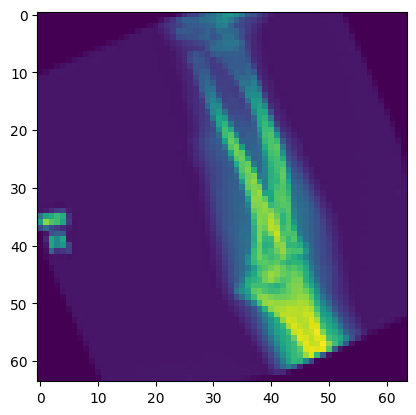

In [112]:
index = 5000

plt.imshow(train_x[index])


width, height = Image.fromarray(train_x[index]).size
print("Width: " + str(width))
print("Height: " + str(height))
print ("y = " + str(train_y[:,index]) + ", it's a '" + classes[np.squeeze(train_y[:,index])].decode("utf-8") +  "' picture.")

Number of samples for each class in the train dataset:

In [113]:
unique_classes, counts = np.unique(train_y, return_counts=True)

for class_label, count in zip(unique_classes, counts):
    print(f'Clase {class_label}: {count} muestras')

Clase 0: 4383 muestras
Clase 1: 4480 muestras


Number of samples for each class in the test dataset:

In [114]:
unique_classes, counts = np.unique(test_y, return_counts=True)

for class_label, count in zip(unique_classes, counts):
    print(f'Clase {class_label}: {count} muestras')

Clase 0: 240 muestras
Clase 1: 360 muestras


## **Preprocessing the Dataset**

In [115]:

# Flatten the training and test images
train_x_flatten = train_x.reshape(train_x.shape[0], -1).T
test_x_flatten = test_x.reshape(test_x.shape[0], -1).T


# Normalize image vectors
train_x_flatten = train_x_flatten/255.
test_x_flatten = test_x_flatten/255.



## **Building the Model**

Defining a function to build a simple neural network model:

In [116]:
from tensorflow.keras.layers import Dropout

# baseline model
def create_baseline():
    model = Sequential()
    model.add(Dense(4096, input_shape=(4096,), activation='relu'))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_baseline()

Shape of the train inputs of the model:

In [117]:
print("X train shape: ", train_x_flatten.shape)
print("Y train shape: ", train_y.shape)

X train shape:  (4096, 8863)
Y train shape:  (1, 8863)


In [118]:
# The model receives (n_samples, n_features) and (n_samples, target) as input

train_x_flatten = train_x_flatten.T
train_y = train_y.T
test_x_flatten = test_x_flatten.T
test_y = test_y.T

In [119]:
model_path = 'models/fracture_detection_model_nn_v1.pkl'
model_history_path = 'models/fracture_detection_model_nn_v1_history.pkl'

the_model_exists = False


if  os.path.exists(model_path):
    print("The model already exists")
    the_model_exists = True
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
    with open(model_history_path, 'rb') as file:
        print("The model history already exists")
        history = pickle.load(file)
    

else:
    # Epochs: Number of times the model is trained on the entire training dataset
    # Batch size: Number of samples to be used in each epoch
    import time

    history = model.fit(train_x_flatten, train_y, epochs=15, batch_size=32, validation_data=(test_x_flatten,test_y))

    # Save the model
    with open(model_path, 'wb') as file:
        pickle.dump(model, file)

    # Save the history
    with open(model_history_path, 'wb') as file:
        pickle.dump(history.history, file)

    
        


The model already exists
The model history already exists


Evaluating the model in the train dataset:

In [120]:
scores = model.evaluate(train_x_flatten, train_y)
print("Accuracy: %.2f%%" % (scores[1]*100))

277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9923 - loss: 0.0211
Accuracy: 98.40%


Evaluating the model in the test dataset:

In [121]:
scores = model.evaluate(test_x_flatten, test_y)
print("Accuracy: %.2f%%" % (scores[1]*100))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7903 - loss: 1.5974
Accuracy: 67.17%


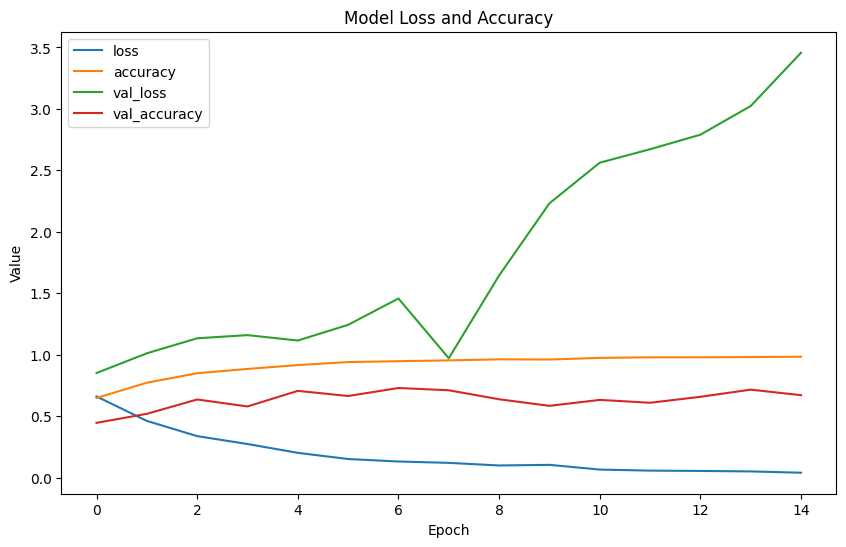

In [122]:
if the_model_exists == False:
    # Plot the history
    plt.figure(figsize=(10, 6))

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')


    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')

    plt.legend()


    plt.title('Model Loss and Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')

    # Show plot
    plt.show()



else:
    plt.figure(figsize=(10, 6))

    plt.plot(history['loss'], label='loss')
    plt.plot(history['accuracy'], label='accuracy')


    plt.plot(history['val_loss'], label='val_loss')
    plt.plot(history['val_accuracy'], label='val_accuracy')

    if 'lr' in history:
        plt.plot(history['lr'], label='lr')


    plt.legend()


    plt.title('Model Loss and Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')

    # Show plot
    plt.show()

It's possible to see that the model is overfitting, which means that it's not generalizing well to the test dataset. To solve this problem, I will use the next steps:

1. Garantee to have a high training accuracy, you can add more layers to the model and increase the number of epochs ✅.
2. If later of some epochs the training loss is decreasing and the validation loss is increasing, it is a sign of overfitting.




## **Grid Search for Hyperparameter Tuning**

In [123]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_baseline_2(optimizer='adam', activation='relu', loss='binary_crossentropy'):
    model = Sequential()
    model.add(Dense(512, input_shape=(4096,), activation=activation))
    model.add(Dense(256, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model


model = KerasClassifier(build_fn=create_baseline_2, verbose=2, epochs=10)

param_grid = {
    'batch_size': [16, 32, 64],
    'optimizer': ['adam', 'rmsprop', 'sgd'],  
    'loss': ['binary_crossentropy', 'mean_squared_error'],
    'epochs': [10, 20, 30],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2)
#grid_result = grid.fit(train_x_flatten, train_y)  

#print("Mejor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

In [124]:
from keras import regularizers

def create_baseline_updated(optimizer='adam', activation='relu', loss='binary_crossentropy'):
    model = Sequential()
    model.add(Dense(512, input_shape=(4096,), activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model


model_path = 'models/fracture_detection_model_nn_v2.pkl'
model_history_path = 'models/fracture_detection_model_nn_v2_history.pkl'

the_model_exists = False


if  os.path.exists(model_path):
    print("The model already exists")
    the_model_exists = True
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
    with open(model_history_path, 'rb') as file:
        print("The model history already exists")
        history = pickle.load(file)
    

else:
    # Epochs: Number of times the model is trained on the entire training dataset
    # Batch size: Number of samples to be used in each epoch


    model = create_baseline_updated()

    history = model.fit(train_x_flatten, train_y, epochs=10, batch_size=32,validation_data=(test_x_flatten,test_y))


    scores = model.evaluate(test_x_flatten, test_y)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    # Save the model
    with open(model_path, 'wb') as file:
        pickle.dump(model, file)

    # Save the history
    with open(model_history_path, 'wb') as file:
        pickle.dump(history.history, file)




Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5839 - loss: 0.7226 - val_accuracy: 0.5000 - val_loss: 0.6741
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7198 - loss: 0.5418 - val_accuracy: 0.4967 - val_loss: 0.8453
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7757 - loss: 0.4585 - val_accuracy: 0.5300 - val_loss: 0.8240
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8060 - loss: 0.4008 - val_accuracy: 0.6350 - val_loss: 0.9856
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8549 - loss: 0.3201 - val_accuracy: 0.5117 - val_loss: 1.1906
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8686 - loss: 0.2944 - val_accuracy: 0.6400 - val_loss: 0.9222
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8865 - loss: 0.2679 - val_accuracy: 0.5883 - val_loss: 0.8369
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8989 - loss: 0.2329 - val_accu

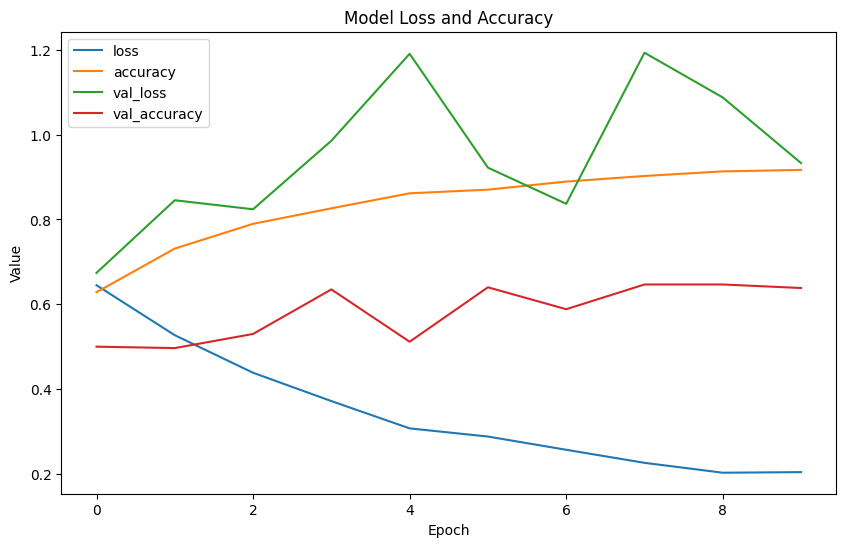

In [125]:
if the_model_exists == False:
    # Plot the history
    plt.figure(figsize=(10, 6))

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')


    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')

    plt.legend()


    plt.title('Model Loss and Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')

    # Show plot
    plt.show()



else:
    plt.figure(figsize=(10, 6))

    plt.plot(history['loss'], label='loss')
    plt.plot(history['accuracy'], label='accuracy')


    plt.plot(history['val_loss'], label='val_loss')
    plt.plot(history['val_accuracy'], label='val_accuracy')

    if 'lr' in history:
        plt.plot(history['lr'], label='lr')


    plt.legend()


    plt.title('Model Loss and Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')

    # Show plot
    plt.show()